# Single Loop HYDRAD Model


In [25]:
import numpy as np
import h5py
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map

import synthesizAR

%matplotlib inline

We'll choose one of the core loops from our AR (from the intermediate frequency), construct a HYDRAD simulation from it, and then compute the AIA 131 angstrom emission from the HYDRAD output. We'd like to know two different things:

1. Does the loop reach temperatures > 10 MK?
2. Is there significant 131 emission emitted by these core loops?

If the answer to number 2 is yes, the next step would be to run a small AR simulation using only a subset of the loops from the AR in the core. We could then compute the timelags for these and see whether we get negative timelags in the 131 pairs as we do in the observations.

## Setup Loop Model

## Import and Clean Results

In [32]:
ar_cooling = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling/field_checkpoint/')
ar_random = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/cooling_outofphase_long/field_checkpoint/')
ar_high = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/high_frequency/field_checkpoint/')
ar_intermediate = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/intermediate_frequency/field_checkpoint/')
ar_low = synthesizAR.Field.restore('/storage-home/w/wtb2/data/timelag_synthesis_v2/low_frequency/field_checkpoint/')

In [133]:
lc_left = SkyCoord(Tx=-320*u.arcsec,Ty=-225*u.arcsec,frame=ar_cooling.magnetogram.coordinate_frame)
lc_right = SkyCoord(Tx=-235*u.arcsec,Ty=-220*u.arcsec,frame=ar_cooling.magnetogram.coordinate_frame)
w,h = 20*u.arcsec,20*u.arcsec

In [134]:
core_loop_indices = []
loops_length_cut = [(i,l) for i,l in enumerate(ar_cooling.loops) if 10*u.Mm < l.full_length < 150*u.Mm]
for i,loop in loops_length_cut:
    coord = loop.coordinates.transform_to('heliographic_stonyhurst').transform_to(ar_cooling.magnetogram.coordinate_frame)
    if (lc_left.Tx < coord[0].Tx < lc_left.Tx + w and lc_left.Ty < coord[0].Ty < lc_left.Ty + h
        and lc_right.Tx < coord[-1].Tx < lc_right.Tx + w and lc_right.Ty < coord[-1].Ty < lc_right.Ty + h):
        core_loop_indices.append(i)

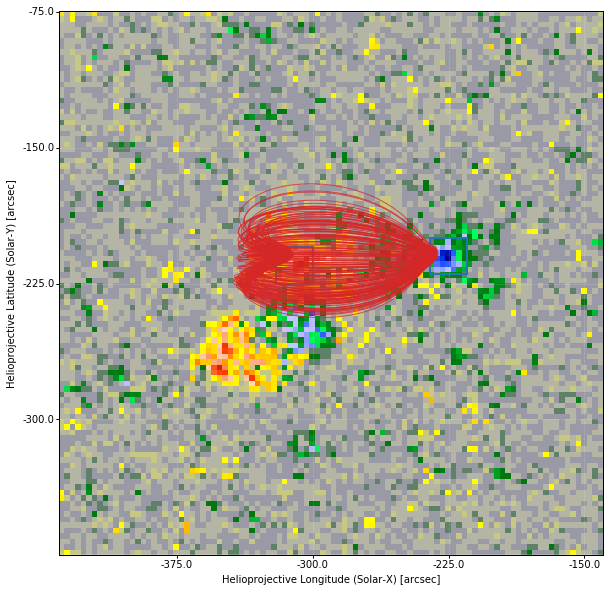

In [136]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=ar_cooling.magnetogram)
ar_cooling.magnetogram.plot(axes=ax, title=False, cmap='hmimag', norm = matplotlib.colors.Normalize(vmin=-1.5e3, vmax=1.5e3))
ar_cooling.magnetogram.draw_rectangle(lc_left,w,h,lw=2,color='C0',axes=ax,)
ar_cooling.magnetogram.draw_rectangle(lc_right,w,h,lw=2,color='C0',axes=ax,)
#ax.grid(alpha=0.)
for i_core in core_loop_indices[:]:
    coord = ar_cooling.loops[i_core].coordinates.transform_to('heliographic_stonyhurst').transform_to(
        ar_cooling.magnetogram.coordinate_frame)
    ax.plot_coord(coord, '-', color='C3', lw=1,alpha=0.75)

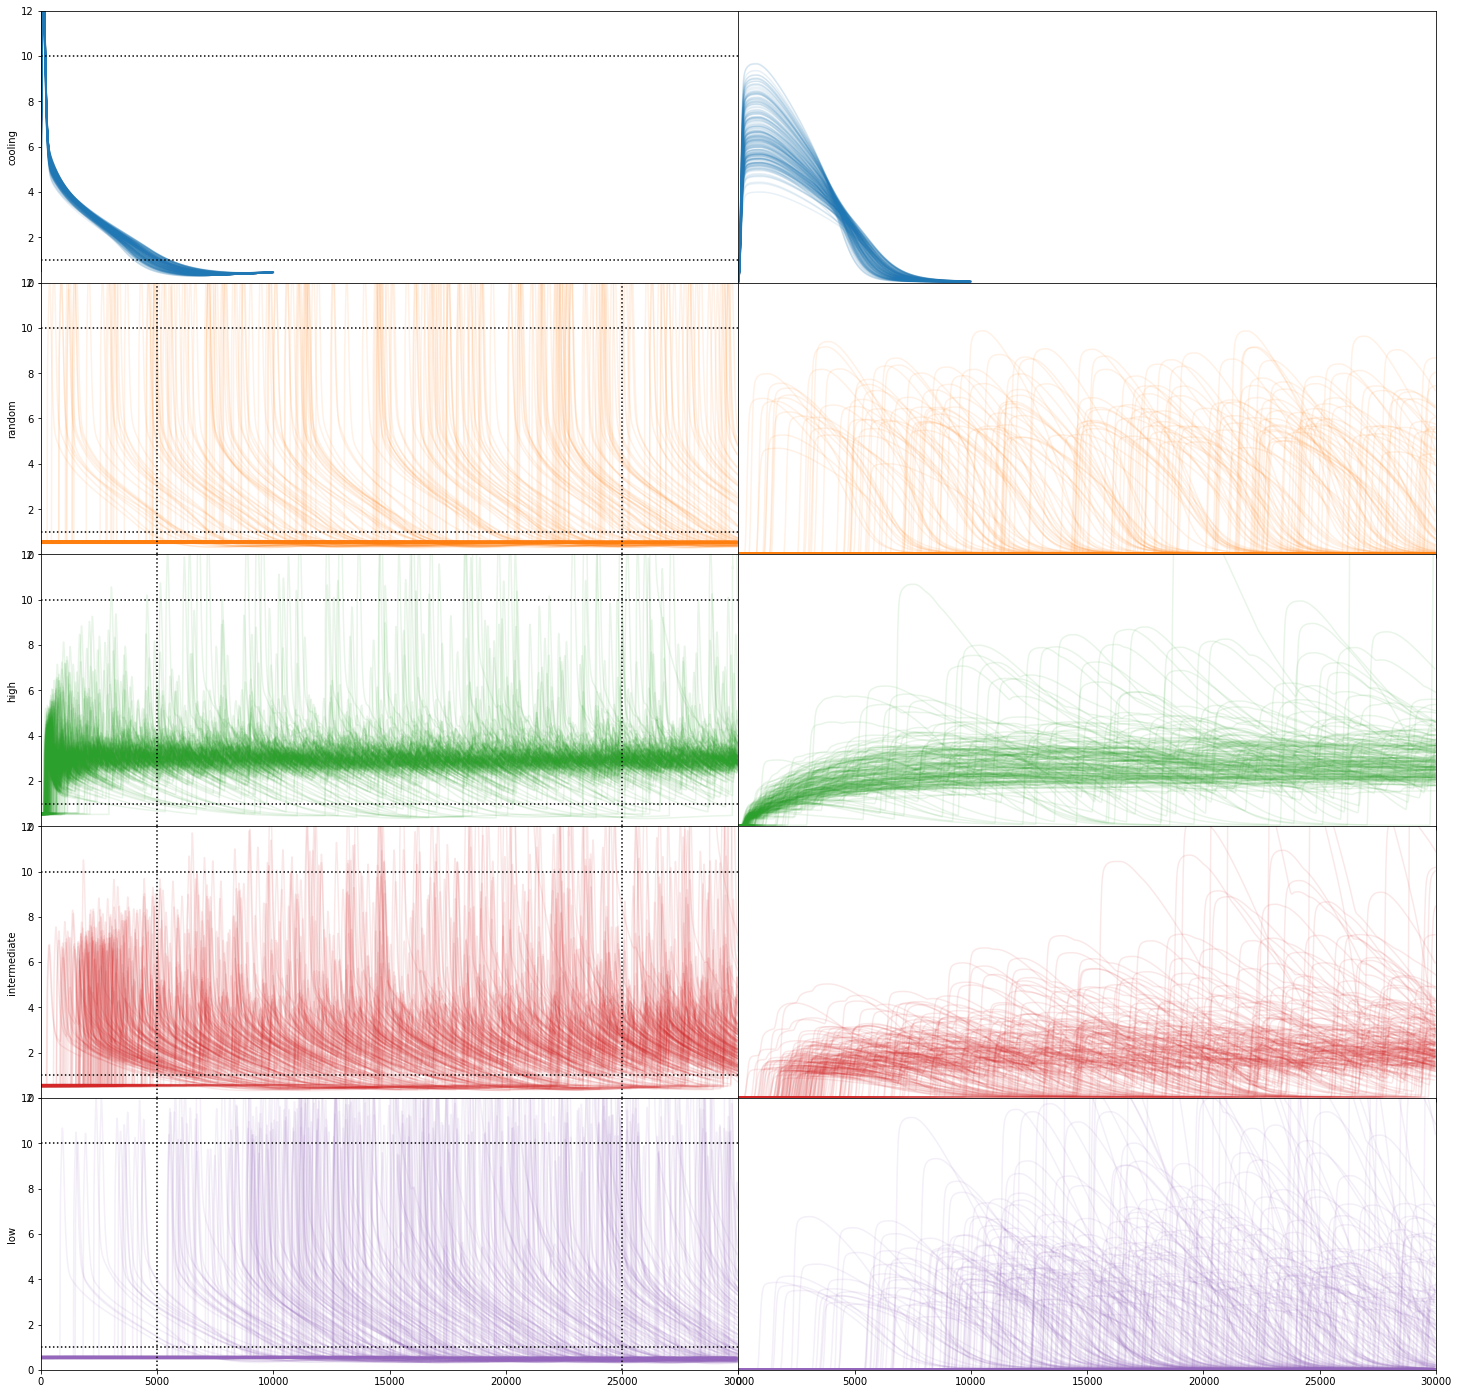

In [137]:
labels = ['cooling','random','high','intermediate','low']
fields = [ar_cooling,ar_random,ar_high,ar_intermediate,ar_low]
alpha = 0.1
freq = 1
fig,axes = plt.subplots(5,2,figsize=(25,25),sharex=True)
plt.subplots_adjust(hspace=0.,wspace=0)
for j,(lab,ar) in enumerate(zip(labels,fields)):
    axes[j,0].set_ylabel(lab)
    for i,index in enumerate(core_loop_indices[::freq]):
        axes[j,0].plot(ar.loops[index].time,ar.loops[index].electron_temperature[:,0].to(u.MK),alpha=alpha,color=f'C{j}')
        axes[j,1].plot(ar.loops[index].time,ar.loops[index].density[:,0]/1e9,alpha=alpha,color=f'C{j}')
    #axes[0].legend(ncol=2,loc=1)
    axes[j,0].set_xlim(0,3e4)
    axes[j,0].set_ylim(0,12)
    axes[j,1].set_ylim(0,5)
    axes[j,0].axhline(y=10,ls=':',color='k')
    axes[j,0].axhline(y=1,ls=':',color='k')
    if j != 0:
        axes[j,0].axvline(x=5e3,ls=':',color='k')
        axes[j,0].axvline(x=25e3,ls=':',color='k')
    axes[j,1].set_yticks([])

In [131]:
m = Map('/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/aia_lev1.5_20110212T175857_131_cutout.fits')

/storage-home/w/wtb2/anaconda3/envs/synthesized-timelags/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


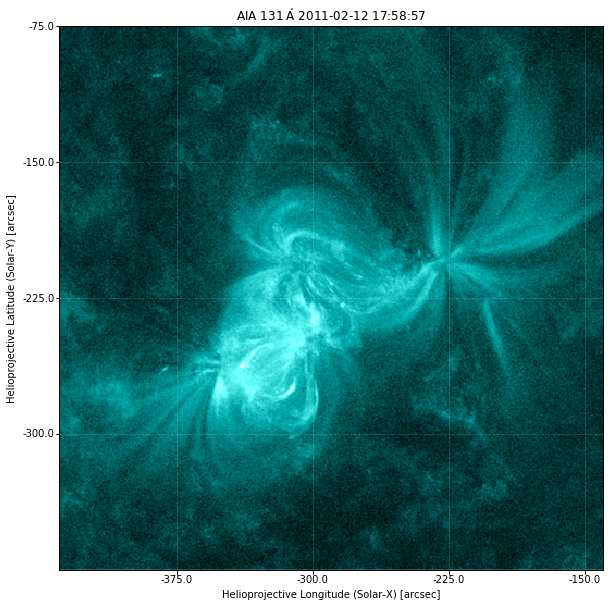

In [132]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection=m)
m.plot(axes=ax)

## Compute 131 Emission